# Import data

In [ ]:
import tensorflow as tf
import os
os.environ['OMP_NUM_THREADS'] = '1'

In [2]:
import pandas as pd
import numpy as np

ins_df = pd.read_csv('data/instagram_data.csv')
ins_df = ins_df[ins_df['Contents'].notna()] # We might want to do something different here - SN
ins_df

,imagename,postid,dataset,dataset.1,postdate,Contents,url,Q1_pertain_to_covid,Q2_cetegory,Q2A_Type of Human,...,Q8_threat_covid,Q9_susceptibility_covid,Q9A_Asian responsible for the covid,Q10_solution_present,Q11_recommended_solution,misinformation,Q12 Presence of conspiracy theory,Q12-Others,Q13. Image of plague doctor costume,Note
0,B-A5FIIIEKJ,5592,middle,2,3/21/20,#covid #covid2020 #covidvirus #virus #coronava...,https://www.instagram.com/p/B-A5FIIIEKJ/,1,1,1,...,1,1,2,1,1,0,2,99,2.0,Stay home
1,B-A74YQn_4a,5593,middle,2,3/21/20,Well this is the final mural of my trip in Aus...,https://www.instagram.com/p/B-A74YQn_4a/,1,1,1,...,1,1,2,2,99,0,2,99,2.0,NaN
2,B-AajnDp6GQ,5575,middle,2,3/21/20,Chegamos !!! Vão seguindo o movimento... Tem m...,https://www.instagram.com/p/B-AajnDp6GQ/,2,99,99,...,99,99,99,99,99,0,99,99,99.0,NaN
3,B-AarR4pUQA,5576,middle,2,3/21/20,😻😻😻😻😻,https://www.instagram.com/p/B-AarR4pUQA/,2,99,99,...,99,99,99,99,99,0,99,99,99.0,NaN
4,B-AE1y3HD-Z,5550,middle,2,3/21/20,EN MI DOMICILIO 🏡\r\r\r\r\n#quedateencasa\r\r\...,https://www.instagram.com/p/B-AE1y3HD-Z/,1,1,1,...,1,1,2,1,1,0,2,99,2.0,mask; Stay home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9643,CEZyheBgtMd,8402,second,3,8/27/20,#water #foryou #followforfollowback #photograp...,https://www.instagram.com/p/CEZyheBgtMd/,2,99,99,...,99,99,99,99,99,0,99,99,99.0,NaN
9644,CEZYoyRluKG,8352,second,3,8/27/20,#like4likes #20likes #tagforlikes #instalikes ...,https://www.instagram.com/p/CEZYoyRluKG/,2,99,99,...,99,99,99,99,99,0,99,99,99.0,NaN
9645,CEZz-solaUF,8403,second,3,8/27/20,🙈🥰😍👉🏽 @love_serie_karma #daancorona #daancoron...,https://www.instagram.com/p/CEZz-solaUF/,2,99,99,...,99,99,99,99,99,0,99,99,99.0,NaN
9646,CEZZ4P4j3rh,8354,second,3,8/27/20,💥🚨 𝗙𝗔𝗟𝗟 𝗜𝗦 𝗖𝗢𝗠𝗜𝗡𝗚 🚨💥⁣\r\r\r\r\r\n⁣\r\r\r\r\r\n...,https://www.instagram.com/p/CEZZ4P4j3rh/,2,99,99,...,99,99,99,99,99,0,99,99,99.0,NaN


In [3]:
from sklearn.utils import shuffle

anger_df = pd.read_csv('data/twitter/anger.tsv', sep='\t').drop(columns=['index', 'intensity'])
fear_df = pd.read_csv('data/twitter/fear.tsv', sep='\t').drop(columns=['index', 'intensity'])
joy_df = pd.read_csv('data/twitter/joy.tsv', sep='\t').drop(columns=['index', 'intensity'])
sadness_df = pd.read_csv('data/twitter/sadness.tsv', sep='\t').drop(columns=['index', 'intensity'])

emotion_df = pd.concat([anger_df, fear_df, joy_df, sadness_df])
emotion_df = shuffle(emotion_df)

emotion_df

,tweet,category
903,#aliens #zombie #gore #slash #ghost #sith #hor...,fear
392,@TouchPH The solution is to punish the crimin...,sadness
415,I think they may be #offended,anger
121,"SOMEONE LET SNAKES IN MY HOUSE, I BET IT @Ya_B...",anger
349,#NewYork: Several #Baloch &amp; Indian activis...,fear
...,...,...
154,@Olajide_Shutti lmaoo. It will be a joyful day.,joy
283,"@Miami4Trump Yeah, but bad part is the #terror...",fear
263,Peter is aesthetically pleasing to look at,joy
62,I had a panic attack when I couldn't find @kat...,fear


# Feature Engineering

In [4]:
!pip install --upgrade transformers datasets emoji deep-translator

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/pkg.7/python3/3.8.10/install/bin/python3.8 -m pip install --upgrade pip' command.


In [5]:
import torch
from transformers import AutoTokenizer
from deep_translator import GoogleTranslator
import emoji
# MODEL = "cardiffnlp/twitter-roberta-base-sentiment" 
# MODEL = "digitalepidemiologylab/covid-twitter-bert-v2"
MODEL = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
translator = GoogleTranslator(source='auto', target='en')

# Note: How we preprocess may depend on model we use to transfer. 
# This comes from https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '' if t.startswith('@') and len(t) > 1 else t
        t = '' if t.startswith('http') else t
        t = t.replace('\r', '')
        t = t.replace("\n", " ") # Remove newlines
        
        # Remove hashtags but keep words
        t = ' '.join(t.split("#")) if '#' in t else t
#         t = '' if len(t.split()) == 0 else t
#         t = '' if len(t.split()) == 1 and t.split()[0] == '#' else t # remove empty "#"
#         if len(t.split("#")) > 1:
#             t = ' #'.join(t.split("#"))[1:] # separate hashtags
            
        # change emojis to be explanation of emoji
        if emoji.get_emoji_regexp().search(t) != None:
            t = ' '.join(emoji.demojize(i) for i in emoji.get_emoji_regexp().split(t))
            t = t.replace("_"," ")
            t = t.replace("-"," ")
            t = t.replace(":"," ")
    #         t = emoji.get_emoji_regexp().sub("", t)
    
        t = " ".join(t.split()) # Remove excess whitespace
        new_text.append(t)
    
    cleaned_text = " ".join(new_text)
     try:
         cleaned_text = translator.translate(cleaned_text) # Translate non english to english
     except Exception as e:
         print(e)
    
    if len(cleaned_text.split()) == 0: return text # return original text if our cleaning made empty string
    return cleaned_text

# Load data into numpy arrays
X = np.array(emotion_df['tweet'])
Y = np.array(emotion_df['category'])
Y_ints = np.array(pd.factorize(emotion_df['category'])[0])
X_ins = np.array(ins_df['Contents'])
east_asian = np.array(ins_df['Q5A.  If yes to Q5, what type of Asian'] == 1, dtype=int)

# Preprocess text
for i in range(len(X)):     X[i] = preprocess(X[i])
for i in range(len(X_ins)): X_ins[i] = preprocess(X_ins[i])
# for i in range(30): 
#     print(X_ins[i])
#     print('---')
#     X_ins[i] = preprocess(X_ins[i])
# #     print(X_ins[i])
#     print()
#     print()

# Split into train/val/test sets
TRAIN_PCT, VAL_PCT, TEST_PCT  = 0.6, 0.2, 0.2
train_idx = int(TRAIN_PCT * len(X))
val_idx = train_idx + int(VAL_PCT * len(X))

In [6]:
for i in range(30): 
    print(X_ins[i])

covid covid2020 covidvirus virus coronavairus coronavirus coronavírus coronavirüs blackandwhite blackandwhiteportrait blackandwhitephoto blackandwhite_photos lockdown lockdown2020 lockdownlife lockdownitaly italylockdown lockdowndiaries lockdownactivities stayathome staysafe stayhome iorestoacasa myhome covid19 covıd19 covi̇d_19 coviditalia black heart black heart black heart black heart
Well this is the final mural of my trip in Australia, a very weird trip, to be honest I couldn’t connect with my painting, at the beginning it was a popular psicosis which looked unreal, then the airline call me with news that my flights was rebooked for 4 month later, I still had a lot to do, people to meet and paint to make, it was super sad when I had to buy another thicket a week before of planed and run out of the country, the same day they closed the border, I like to think that everything happens for reason, everything is meant to be ... if this is my way to start the painting tour this year I d

In [7]:
X_train, Y_train = X[:train_idx], Y_ints[:train_idx]
X_val, Y_val = X[train_idx:val_idx], Y_ints[train_idx:val_idx]
X_test, Y_test = X[val_idx:], Y_ints[val_idx:]

# Tokenize the data
X_train_enc = tokenizer(list(X_train), return_tensors='pt', padding=True, truncation=True)
X_val_enc = tokenizer(list(X_val), return_tensors='pt', padding=True, truncation=True)
X_test_enc = tokenizer(list(X_test), return_tensors='pt', padding=True, truncation=True)
X_ins_enc = tokenizer(list(X_ins), return_tensors='pt', padding=True, truncation=True, max_length=308)

# Model Definition

In [8]:
# TODO: define our machine learning model, from our discussion it we can try deep learning models

import os
from torch.utils.data import (
    Dataset, 
    DataLoader, 
    RandomSampler, 
    SequentialSampler
)

import math 
from transformers import  (
    BertPreTrainedModel, 
    RobertaConfig, 
    RobertaTokenizerFast
)

from transformers.optimization import (
    AdamW, 
    get_linear_schedule_with_warmup
)

from scipy.special import softmax
from torch.nn import CrossEntropyLoss

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    matthews_corrcoef,
    roc_curve,
    auc,
    average_precision_score,
    accuracy_score
)

from transformers.models.roberta.modeling_roberta import (
    RobertaClassificationHead,
    RobertaConfig,
    RobertaModel,
)

from transformers import AutoModel
from torch import nn

num_labels = 4

In [9]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('Number of GPUs: ',torch.cuda.device_count())
else:
    print('No GPU, using CPU.')
    device = torch.device("cpu")

Number of GPUs:  1


In [10]:
max_seq_length = 128 
train_batch_size = 8
test_batch_size = 8
warmup_ratio = 0.06
weight_decay=0.0
gradient_accumulation_steps = 1
num_train_epochs = 5 
learning_rate = 1e-05
adam_epsilon = 1e-08

In [11]:
class RobertaClassification(BertPreTrainedModel):
    
    def __init__(self, config):
        super(RobertaClassification, self).__init__(config)
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config)
        self.classifier = RobertaClassificationHead(config)
        
        
    def forward(self, input_ids, attention_mask, labels):
        outputs = self.roberta(input_ids,attention_mask=attention_mask)
        sequence_output = outputs[0]
        
        logits = self.classifier(sequence_output)

        outputs = (logits,) + outputs[2:]
        
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

config_class = RobertaConfig
model_class = RobertaClassification

config = config_class.from_pretrained(MODEL, num_labels=num_labels)
model = model_class.from_pretrained(MODEL, config=config)


# class Model(nn.Module):
#     def __init__(self, MODEL, num_labels):
#         super(Model, self).__init__()
#         self.num_labels = num_labels
#         self.pretrained_model = AutoModel.from_pretrained(MODEL)
# #         self.drop1 = nn.Dropout(0.2)
#         self.linear1 = nn.Linear(768, 768)
#         self.relu = nn.ReLU()
# #         self.drop2 = nn.Dropout(0.2)
#         self.linear2 = nn.Linear(768, self.num_labels)

#     def forward(self, input_ids, attention_mask, labels):
#         output = self.pretrained_model(input_ids, attention_mask=attention_mask)
#         l1 = self.relu(self.linear1(output.pooler_output))
#         out = self.linear2(l1)
        
#         loss_fct = CrossEntropyLoss()
#         loss = loss_fct(out.view(-1, self.num_labels), labels.view(-1))
        
#         return loss, out

# model = Model(MODEL, num_labels)
print('Model=\n',model,'\n')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this 

Model=
 RobertaClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm

In [12]:
class MyClassificationDataset(Dataset):
    
    def __init__(self, data,y):
        text = data
        labels=y
        self.examples = text
#         targets = tr.transform(labels)
        self.labels = torch.as_tensor(labels, dtype=torch.long)
        

    def __len__(self):
        return len(self.examples["input_ids"])

    def __getitem__(self, index):
        return {key: self.examples[key][index] for key in self.examples}, self.labels[index]


train_dataset = MyClassificationDataset(X_train_enc,Y_train)
val_dataset = MyClassificationDataset(X_val_enc, Y_val)
test_dataset = MyClassificationDataset(X_test_enc, Y_test)
ins_dataset = MyClassificationDataset(X_ins_enc, [0.] * len(X_ins))

<ipython-input-12-011184b67429>:8: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  self.labels = torch.as_tensor(labels, dtype=torch.long)


In [13]:
train_batch_size = 8
val_batch_size = 8
test_batch_size = 8

def get_inputs_dict(batch):
    inputs = {key: value.squeeze(1).to(device) for key, value in batch[0].items()}
    inputs["labels"] = batch[1].to(device)
    return inputs

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset,sampler=train_sampler,batch_size=train_batch_size)

val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=val_batch_size)

test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=test_batch_size)

ins_sampler = SequentialSampler(ins_dataset)
ins_dataloader = DataLoader(ins_dataset, sampler=ins_sampler, batch_size=test_batch_size)

#Extract a batch as sanity-check
batch = get_inputs_dict(next(iter(train_dataloader)))
input_ids = batch['input_ids'].to(device)
attention_mask = batch['attention_mask'].to(device)
labels = batch['labels'].to(device)
print(batch)

{'input_ids': tensor([[    0,  7389, 44128,  ...,     1,     1,     1],
        [    0,   100,   437,  ...,     1,     1,     1],
        [    0,     4,  1437,  ...,     1,     1,     1],
        ...,
        [    0, 19807,    15,  ...,     1,     1,     1],
        [    0,  5975,    51,  ...,     1,     1,     1],
        [    0, 13368,   117,  ...,     1,     1,     1]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'), 'labels': tensor([1, 3, 1, 0, 0, 2, 1, 0], device='cuda:0')}


In [14]:
def setup_opts(model):
    t_total = len(train_dataloader) // gradient_accumulation_steps * num_train_epochs
    optimizer_grouped_parameters = []
    custom_parameter_names = set()
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters.extend(
        [
            {
                "params": [
                    p
                    for n, p in model.named_parameters()
                    if n not in custom_parameter_names and not any(nd in n for nd in no_decay)
                ],
                "weight_decay": weight_decay,
            },
            {
                "params": [
                    p
                    for n, p in model.named_parameters()
                    if n not in custom_parameter_names and any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
    )

    warmup_steps = math.ceil(t_total * warmup_ratio)
    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)
    return optimizer, scheduler

optimizer, scheduler = setup_opts(model)

# Training

In [15]:
# TODO: train our model using the loaded data
model.to(device)

model.zero_grad()

def log_metrics(y, y_preds):
    print(classification_report(y, y_preds, target_names=['Joy', 'Fear', 'Sadness', 'Anger']))
    

def train_epochs(num_train_epochs):
    avg_loss=[]
    avg_val_loss=[]
    for epoch in range(num_train_epochs):

        model.train()
        epoch_loss = []
    
        for batch in train_dataloader:
            batch = get_inputs_dict(batch)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            loss.backward()
            optimizer.step()
            scheduler.step()
            model.zero_grad()
            epoch_loss.append(loss.item())
        
        #evaluate model with test_df at the end of the epoch.
        eval_loss = 0.0
        nb_eval_steps = 0
        n_batches = len(val_dataloader)
        preds = np.empty((len(val_dataset), num_labels))
        out_label_ids = np.empty((len(val_dataset)))
        model.eval()
    
        for i,test_batch in enumerate(val_dataloader):
            with torch.no_grad():
                test_batch = get_inputs_dict(test_batch)
                input_ids = test_batch['input_ids'].to(device)
                attention_mask = test_batch['attention_mask'].to(device)
                labels = test_batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                tmp_eval_loss, logits = outputs[:2]
                eval_loss += tmp_eval_loss.item()
            
            nb_eval_steps += 1
            start_index = test_batch_size * i
            end_index = start_index + test_batch_size if i != (n_batches - 1) else len(test_dataset)
            preds[start_index:end_index] = logits.detach().cpu().numpy()
            out_label_ids[start_index:end_index] = test_batch["labels"].detach().cpu().numpy()
        
        eval_loss = eval_loss / nb_eval_steps
        model_outputs = preds
        preds = np.argmax(preds, axis=1)
        #result, wrong = compute_metrics(preds, model_outputs, out_label_ids)
        epoch_loss=np.mean(epoch_loss)
        print('epoch',epoch,'Training avg loss',epoch_loss)
        print('epoch',epoch,'Testing  avg loss',eval_loss)
        print('---------------------------------------------------\n')
        avg_loss.append(epoch_loss)
        avg_val_loss.append(eval_loss)
        
    report=log_metrics(Y_val, preds)
    print(report)
    avg_loss=np.mean(avg_loss)
    avg_val_loss=np.mean(avg_val_loss)
    accuracy=accuracy_score(Y_val, preds)
    return avg_loss,avg_val_loss,report,accuracy
        

# Performance Evaluation

In [16]:
def test():   
    model.to(device)
    eval_loss = 0.0
    nb_eval_steps = 0
    n_batches = len(test_dataloader)
    preds = np.empty((len(test_dataset), num_labels))
    out_label_ids = np.empty((len(test_dataset)))
    model.eval()
    for i,test_batch in enumerate(test_dataloader):
        with torch.no_grad():
            test_batch = get_inputs_dict(test_batch)
            input_ids = test_batch['input_ids'].to(device)
            attention_mask = test_batch['attention_mask'].to(device)
            labels = test_batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            tmp_eval_loss, logits = outputs[:2]
            eval_loss += tmp_eval_loss.item()

        nb_eval_steps += 1
        start_index = test_batch_size * i
        end_index = start_index + test_batch_size if i != (n_batches - 1) else len(test_dataset)
        preds[start_index:end_index] = logits.detach().cpu().numpy()
        out_label_ids[start_index:end_index] = test_batch["labels"].detach().cpu().numpy()

    eval_loss = eval_loss / nb_eval_steps
    model_outputs = preds
    preds = np.argmax(preds, axis=1)
    print("classification report for test set")
    print(log_metrics(Y_test, preds))
    accuracy=accuracy_score(Y_test, preds)
    return eval_loss,accuracy

In [17]:
train_loss=[]
val_loss=[]
val_acc=[]
test_loss=[]
test_acc=[]
for epoch in range(2,12,2):
    print("train with epochs=",epoch)
    model = model_class.from_pretrained(MODEL, config=config)
#     model = Model(num_labels)
    model.to(device)
    optimizer, scheduler = setup_opts(model)
    
    avg_loss,avg_val_loss,report,accuracy=train_epochs(epoch)
    
    train_loss.append(avg_loss)
    val_loss.append(avg_val_loss)
    val_acc.append(accuracy)
    testloss,testacc=test()
    test_loss.append(testloss)
    test_acc.append(testacc)

train with epochs= 2


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this 

epoch 0 Training avg loss 1.1816222612158398
epoch 0 Testing  avg loss 0.6051256581322177
---------------------------------------------------

epoch 1 Training avg loss 0.5283586812580203
epoch 1 Testing  avg loss 0.4436520438354749
---------------------------------------------------

              precision    recall  f1-score   support

         Joy       0.85      0.79      0.82       229
        Fear       0.86      0.80      0.83       148
     Sadness       0.78      0.85      0.81       177
       Anger       0.89      0.93      0.91       168

    accuracy                           0.84       722
   macro avg       0.84      0.84      0.84       722
weighted avg       0.84      0.84      0.84       722

None
classification report for test set
              precision    recall  f1-score   support

         Joy       0.83      0.77      0.80       220
        Fear       0.84      0.76      0.80       160
     Sadness       0.78      0.90      0.83       162
       Anger       0.8

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this 

epoch 0 Training avg loss 1.205764988471661
epoch 0 Testing  avg loss 0.6372908180231577
---------------------------------------------------

epoch 1 Training avg loss 0.5534690967675064
epoch 1 Testing  avg loss 0.4580742365547589
---------------------------------------------------

epoch 2 Training avg loss 0.33880221028554486
epoch 2 Testing  avg loss 0.4070510159113577
---------------------------------------------------

epoch 3 Training avg loss 0.2398886723354514
epoch 3 Testing  avg loss 0.4232915523922542
---------------------------------------------------

              precision    recall  f1-score   support

         Joy       0.86      0.84      0.85       229
        Fear       0.84      0.84      0.84       148
     Sadness       0.85      0.82      0.83       177
       Anger       0.88      0.93      0.90       168

    accuracy                           0.86       722
   macro avg       0.86      0.86      0.86       722
weighted avg       0.86      0.86      0.86     

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this 

epoch 0 Training avg loss 1.2513474057741272
epoch 0 Testing  avg loss 0.7225195212023598
---------------------------------------------------

epoch 1 Training avg loss 0.5447131183644502
epoch 1 Testing  avg loss 0.4298951848113275
---------------------------------------------------

epoch 2 Training avg loss 0.32240494855463064
epoch 2 Testing  avg loss 0.3977821355501374
---------------------------------------------------

epoch 3 Training avg loss 0.23325595681682723
epoch 3 Testing  avg loss 0.39852617472246454
---------------------------------------------------

epoch 4 Training avg loss 0.1765635464807828
epoch 4 Testing  avg loss 0.3984152724823126
---------------------------------------------------

epoch 5 Training avg loss 0.1634391503497903
epoch 5 Testing  avg loss 0.3984152724823126
---------------------------------------------------

              precision    recall  f1-score   support

         Joy       0.86      0.86      0.86       229
        Fear       0.85      0

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this 

epoch 0 Training avg loss 1.2514736533604864
epoch 0 Testing  avg loss 0.7425822622173435
---------------------------------------------------

epoch 1 Training avg loss 0.6094019524615629
epoch 1 Testing  avg loss 0.4634258309481563
---------------------------------------------------

epoch 2 Training avg loss 0.3604557133001375
epoch 2 Testing  avg loss 0.4314994557996045
---------------------------------------------------

epoch 3 Training avg loss 0.26455902374208634
epoch 3 Testing  avg loss 0.41864777712540313
---------------------------------------------------

epoch 4 Training avg loss 0.2085769503305209
epoch 4 Testing  avg loss 0.419260175632579
---------------------------------------------------

epoch 5 Training avg loss 0.187815978806947
epoch 5 Testing  avg loss 0.419260175632579
---------------------------------------------------

epoch 6 Training avg loss 0.19299065500387846
epoch 6 Testing  avg loss 0.419260175632579
---------------------------------------------------



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this 

epoch 0 Training avg loss 1.3056872443079508
epoch 0 Testing  avg loss 0.912159861771615
---------------------------------------------------

epoch 1 Training avg loss 0.6340890712073808
epoch 1 Testing  avg loss 0.4488995786305967
---------------------------------------------------

epoch 2 Training avg loss 0.35541239926570894
epoch 2 Testing  avg loss 0.4552898897001377
---------------------------------------------------

epoch 3 Training avg loss 0.2598115930615536
epoch 3 Testing  avg loss 0.4243820329493546
---------------------------------------------------

epoch 4 Training avg loss 0.20691258078819053
epoch 4 Testing  avg loss 0.4268934504732817
---------------------------------------------------

epoch 5 Training avg loss 0.18504840075777246
epoch 5 Testing  avg loss 0.4268934504732817
---------------------------------------------------

epoch 6 Training avg loss 0.18980547566502956
epoch 6 Testing  avg loss 0.4268934504732817
-------------------------------------------------

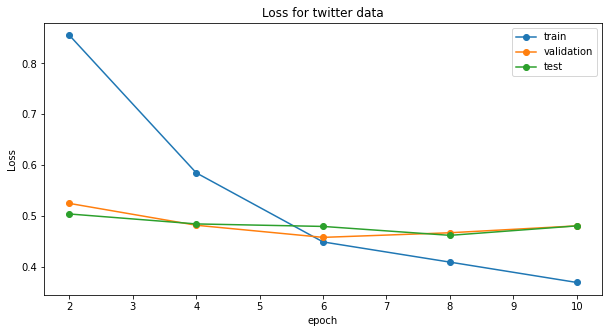

In [18]:
import matplotlib.pyplot as plt

x=[2,4,6,8,10]
plt.figure(figsize=(10,5))
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title("Loss for twitter data")
plt.plot(x,train_loss,marker='o',label='train')
plt.plot(x,val_loss,marker='o',label='validation')
plt.plot(x,test_loss,marker='o',label='test')
plt.legend()

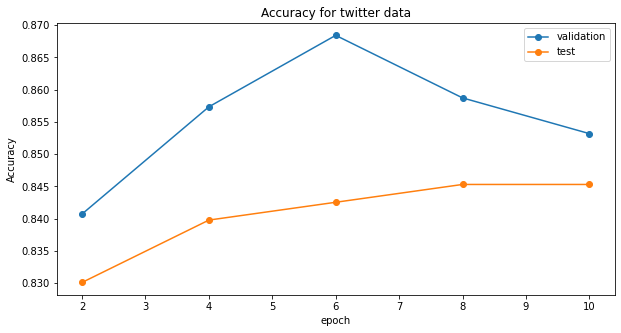

In [20]:
plt.figure(figsize=(10,5))
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title("Accuracy for twitter data")
plt.plot(x,val_acc,marker='o',label='validation')
plt.plot(x,test_acc,marker='o',label='test')
plt.legend()

# Prediction

In [ ]:
# TODO: predict the submission data 
nb_eval_steps = 0
n_batches = len(ins_dataloader)
preds = np.empty((len(ins_dataset), num_labels))
model.eval()
    
for i,test_batch in enumerate(ins_dataloader):
    with torch.no_grad():
        test_batch = get_inputs_dict(test_batch)
        input_ids = test_batch['input_ids'].to(device)
        attention_mask = test_batch['attention_mask'].to(device)
        labels = test_batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        _, logits = outputs[:2]

    nb_eval_steps += 1
    start_index = test_batch_size * i
    end_index = start_index + test_batch_size if i != (n_batches - 1) else len(ins_dataset)
    preds[start_index:end_index] = logits.detach().cpu().numpy()

model_outputs = preds
preds = np.argmax(preds, axis=1)
np.savetxt('instagram_predictions.txt', preds) # We might want to do something different here - SN

In [22]:
from scipy.stats import pearsonr
# from scipy.stats import spearmanr
emotions = ['Joy', 'Fear', 'Sadness', 'Anger']

preds_one_hot = np.zeros((len(preds), preds.max()+1))
preds_one_hot[np.arange(len(preds)),preds] = 1

for i in range(num_labels):
    corr, _ = pearsonr(preds_one_hot[:,i], east_asian)
    print('Correlation with {}: {}'.format(emotions[i], corr))

Correlation with Joy: 0.10961711516111323
Correlation with Fear: -0.03095183092046343
Correlation with Sadness: -0.06202519724378585
Correlation with Anger: -0.053837380005938684


In [24]:
for i in range(20):
    print('Prediction: {} \nProcessed:\n{}\nUnprocessed:\n{}\n\n'.format(emotions[preds[i]], X_ins[i],np.array(ins_df['Contents'])[i]))

Prediction: Joy 
Processed:
covid covid2020 covidvirus virus coronavairus coronavirus coronavírus coronavirüs blackandwhite blackandwhiteportrait blackandwhitephoto blackandwhite_photos lockdown lockdown2020 lockdownlife lockdownitaly italylockdown lockdowndiaries lockdownactivities stayathome staysafe stayhome iorestoacasa myhome covid19 covıd19 covi̇d_19 coviditalia black heart black heart black heart black heart
Unprocessed:
#covid #covid2020 #covidvirus #virus #coronavairus #coronavirus #coronavírus #coronavirüs #blackandwhite #blackandwhiteportrait #blackandwhitephoto #blackandwhite_photos #lockdown #lockdown2020 #lockdownlife #lockdownitaly #italylockdown #lockdowndiaries #lockdownactivities #stayathome #staysafe #stayhome #iorestoacasa #myhome #covid19 #covıd19 #covi̇d_19 #coviditalia #🖤 #🖤🖤🖤


Prediction: Fear 
Processed:
Well this is the final mural of my trip in Australia, a very weird trip, to be honest I couldn’t connect with my painting, at the beginning it was a popular p